<a href="https://colab.research.google.com/github/ronaldoaf/999.079_AT_MUDA_STATE_JOB/blob/master/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://aposte.me/files/XAUUSDm_M30.csv
!wget https://aposte.me/files/XAUUSD_30M_2TP_1SL.csv



--2023-06-02 18:57:24--  https://aposte.me/files/XAUUSDm_M30.csv
Resolving aposte.me (aposte.me)... 153.92.6.139, 2a02:4780:a:1079:0:18be:ff35:3
Connecting to aposte.me (aposte.me)|153.92.6.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4827399 (4.6M) [text/plain]
Saving to: ‘XAUUSDm_M30.csv’

XAUUSDm_M30.csv     100%[===================>]   4.60M  5.34MB/s    in 0.9s    

2023-06-02 18:57:25 (5.34 MB/s) - ‘XAUUSDm_M30.csv’ saved [4827399/4827399]

--2023-06-02 18:57:25--  https://aposte.me/files/XAUUSD_30M_2TP_1SL.csv
Resolving aposte.me (aposte.me)... 153.92.6.139, 2a02:4780:a:1079:0:18be:ff35:3
Connecting to aposte.me (aposte.me)|153.92.6.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2607801 (2.5M) [text/plain]
Saving to: ‘XAUUSD_30M_2TP_1SL.csv’

XAUUSD_30M_2TP_1SL. 100%[===================>]   2.49M  1.34MB/s    in 1.9s    

2023-06-02 18:57:27 (1.34 MB/s) - ‘XAUUSD_30M_2TP_1SL.csv’ saved [2607801/2607801]



In [8]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None


import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split


import time


import random

def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()


In [9]:
df= pd.read_csv('XAUUSDm_M30.csv', delimiter="\t")


df['Datetime']=pd.to_datetime(df['DATE'] + ' '+df['TIME'], format='%Y.%m.%d %H:%M')

df=df['Datetime,OPEN,HIGH,LOW,CLOSE,TICKVOL'.split(",")]

df=df.set_index('Datetime')


df['C']=np.log(df.CLOSE) - np.log( df.CLOSE.shift(1) )

df


,OPEN,HIGH,LOW,CLOSE,TICKVOL,C
Datetime,,,,,,
2017-05-02 11:00:00,1255.628,1255.916,1254.940,1255.023,1316,NaN
2017-05-02 11:30:00,1255.023,1255.994,1255.023,1255.686,1371,0.000528
2017-05-02 12:00:00,1255.704,1255.965,1255.274,1255.375,1237,-0.000248
2017-05-02 12:30:00,1255.373,1255.946,1254.712,1254.731,1552,-0.000513
2017-05-02 13:00:00,1254.741,1254.861,1252.584,1252.813,2299,-0.001530
...,...,...,...,...,...,...
2023-05-22 08:30:00,1975.976,1980.731,1975.328,1980.684,1976,0.002381
2023-05-22 09:00:00,1980.681,1982.530,1979.999,1980.524,2041,-0.000081
2023-05-22 09:30:00,1980.535,1981.870,1979.216,1979.633,1778,-0.000450


In [10]:
N=50
cols={}
for i in range(1,N+1):
    for e in ['C']:
        cols[e + str(i)]=df[e].shift(i)
        
df1=pd.DataFrame(cols).dropna()

df1


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-05-03 13:30:00,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,-0.000108,0.000810,-0.000611,-0.000353,...,0.000190,0.000320,-0.000664,0.001429,0.000361,0.000062,-0.001530,-0.000513,-0.000248,0.000528
2017-05-03 14:00:00,-0.000392,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,-0.000108,0.000810,-0.000611,...,0.000319,0.000190,0.000320,-0.000664,0.001429,0.000361,0.000062,-0.001530,-0.000513,-0.000248
2017-05-03 14:30:00,-0.000650,-0.000392,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,-0.000108,0.000810,...,-0.000042,0.000319,0.000190,0.000320,-0.000664,0.001429,0.000361,0.000062,-0.001530,-0.000513
2017-05-03 15:00:00,-0.000398,-0.000650,-0.000392,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,-0.000108,...,0.000096,-0.000042,0.000319,0.000190,0.000320,-0.000664,0.001429,0.000361,0.000062,-0.001530
2017-05-03 15:30:00,-0.003705,-0.000398,-0.000650,-0.000392,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,...,0.000398,0.000096,-0.000042,0.000319,0.000190,0.000320,-0.000664,0.001429,0.000361,0.000062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22 08:30:00,-0.000418,0.000948,-0.000686,0.000480,0.001146,-0.001144,-0.000481,-0.000978,0.000188,0.000411,...,-0.001604,0.000825,-0.001883,0.001369,0.000183,-0.000775,-0.000354,0.000550,0.000701,-0.002097
2023-05-22 09:00:00,0.002381,-0.000418,0.000948,-0.000686,0.000480,0.001146,-0.001144,-0.000481,-0.000978,0.000188,...,0.000626,-0.001604,0.000825,-0.001883,0.001369,0.000183,-0.000775,-0.000354,0.000550,0.000701
2023-05-22 09:30:00,-0.000081,0.002381,-0.000418,0.000948,-0.000686,0.000480,0.001146,-0.001144,-0.000481,-0.000978,...,-0.000597,0.000626,-0.001604,0.000825,-0.001883,0.001369,0.000183,-0.000775,-0.000354,0.000550


In [11]:
df2=pd.read_csv('XAUUSD_30M_2TP_1SL.csv').set_index('open_time')

df2.index=pd.to_datetime(df2.index)


df2

,atr,buy_PL,sell_PL
open_time,,,
2017-05-01 00:00:00,0.998000,-10.14,19.96
2017-05-01 00:30:00,1.024429,-10.29,20.51
2017-05-01 01:00:00,1.001286,-10.05,20.19
2017-05-01 01:30:00,1.005000,-10.18,20.49
2017-05-01 02:00:00,1.154357,-11.81,23.14
...,...,...,...
2022-04-29 18:30:00,5.030786,-50.49,100.75
2022-04-29 19:00:00,4.717071,-47.35,94.47
2022-04-29 19:30:00,4.814929,-48.25,36.52


In [12]:
df3=df1.merge(df2[['buy_PL','sell_PL']], left_index=True, right_index=True)

df3


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C43,C44,C45,C46,C47,C48,C49,C50,buy_PL,sell_PL
2017-05-03 13:30:00,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,-0.000108,0.000810,-0.000611,-0.000353,...,-0.000664,0.001429,0.000361,0.000062,-0.001530,-0.000513,-0.000248,0.000528,-10.91,21.79
2017-05-03 14:00:00,-0.000392,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,-0.000108,0.000810,-0.000611,...,0.000320,-0.000664,0.001429,0.000361,0.000062,-0.001530,-0.000513,-0.000248,-11.76,23.73
2017-05-03 14:30:00,-0.000650,-0.000392,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,-0.000108,0.000810,...,0.000190,0.000320,-0.000664,0.001429,0.000361,0.000062,-0.001530,-0.000513,-12.57,25.22
2017-05-03 15:00:00,-0.000398,-0.000650,-0.000392,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,-0.000108,...,0.000319,0.000190,0.000320,-0.000664,0.001429,0.000361,0.000062,-0.001530,-13.10,26.53
2017-05-03 15:30:00,-0.003705,-0.000398,-0.000650,-0.000392,-0.000368,0.000035,-0.000003,0.000250,-0.000358,0.000055,...,-0.000042,0.000319,0.000190,0.000320,-0.000664,0.001429,0.000361,0.000062,33.65,-16.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 18:30:00,0.000596,-0.000123,0.001021,-0.000341,-0.000401,0.002165,-0.003043,0.000256,-0.000014,0.001093,...,-0.000134,-0.000003,0.001850,0.000572,0.001363,-0.000734,0.000886,0.001416,-50.49,100.75
2022-04-29 19:00:00,-0.001545,0.000596,-0.000123,0.001021,-0.000341,-0.000401,0.002165,-0.003043,0.000256,-0.000014,...,-0.000795,-0.000134,-0.000003,0.001850,0.000572,0.001363,-0.000734,0.000886,-47.35,94.47
2022-04-29 19:30:00,-0.003963,-0.001545,0.000596,-0.000123,0.001021,-0.000341,-0.000401,0.002165,-0.003043,0.000256,...,-0.000329,-0.000795,-0.000134,-0.000003,0.001850,0.000572,0.001363,-0.000734,-48.25,36.52
2022-04-29 20:00:00,-0.002108,-0.003963,-0.001545,0.000596,-0.000123,0.001021,-0.000341,-0.000401,0.002165,-0.003043,...,-0.000443,-0.000329,-0.000795,-0.000134,-0.000003,0.001850,0.000572,0.001363,-0.13,-3.87


In [40]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers,dropout=0.1):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True,dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        n=x.size(0)
        x=x.view(n,x.size(1),1 )
        h0 = torch.zeros(self.n_layers, n, self.hidden_dim).to(x.device) # Initial hidden state
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Output corresponding to the last timestep
        return out



inicio=time.time()

def train(state=0):
  df_train, df_test = train_test_split(df3, test_size=0.1,  random_state=state)



  corte=99.5


  #max_diff=np.percentile([abs(df_train.H1),abs(df_train.L1)], corte )
  max_diff=np.percentile([abs(df_train.C1)], corte )
  max_PL=np.percentile([abs(df_train.buy_PL),abs(df_train.sell_PL)], corte )


  #Coloca em escala de -1 e 1,  99.5% ddos dados
  df_train[df3.columns[:-2]]/=max_diff
  df_test[df3.columns[:-2]]/=max_diff

  df_train[df3.columns[-2:]]/=max_PL
  df_test[df3.columns[-2:]]/=max_PL





  X_train=torch.Tensor(df_train.iloc[:,:-2].values).flip(1)
  Y_train=torch.Tensor(df_train.iloc[:,-2:].values)


  X_test=torch.Tensor(df_test.iloc[:,:-2].values).flip(1)
  Y_test=torch.Tensor(df_test.iloc[:,-2:].values )

  


  D_in=X_train.shape[1]
  D_out=Y_train.shape[1]
  D_h=25


  '''
  model=nn.Sequential(
      nn.Linear(D_in, D_h),
      nn.ReLU(),
      nn.Dropout(p=0.2),
      #nn.Linear(D_h, D_h),
      #nn.ReLU(),
      #nn.Dropout(p=0.2),
      nn.Linear(D_h, D_out)
  )
  '''
  model=GRU(input_dim=1, hidden_dim=25, output_dim=D_out, n_layers=2, dropout=0.1)


  #Se tiver GPU disponivel usa a utiliza para acelerar o processo
  if torch.cuda.is_available():
    X_train=X_train.cuda()
    X_test=X_test.cuda()
    Y_train=Y_train.cuda()
    Y_test=Y_test.cuda()
    model=model.cuda()





  # Loss and optimizer
  loss_func=nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

  epochs = 100
  batch_size=5000   

  losses=[]
  for _ in range(epochs):
      permutation = torch.randperm(X_train.shape[0])
      for i in range(0,X_train.shape[0], batch_size):
          indices = permutation[i:i+batch_size]
          batch_x, batch_y = X_train[indices], Y_train[indices]
          
          optimizer.zero_grad() 
          y_pred = model(batch_x)
          loss = loss_func(y_pred, batch_y)
      
          loss.backward()
          optimizer.step()
      
          #with torch.no_grad():
          #    losses+=[float(loss_func(model(X_test), Y_test).item())]

  #pd.Series(losses[int(epochs/2):]).plot.line()


  model.eval()

  Y_pred=model(X_test)
  k=0.01
  PL_total=Y_test[Y_pred[:,0]>k][:,0].sum()+Y_test[Y_pred[:,1]>k][:,1].sum()

  #return PL_total




  
  dft=pd.DataFrame()

  dft[['buy_pred','sell_pred']]=pd.DataFrame( model(X_test).cpu().detach().numpy() )
  dft[['buy','sell']]=pd.DataFrame(Y_test.detach().cpu().numpy() )


  for i in range(20):
      k=i*0.01
      pl_total= dft[dft.buy_pred>k].buy.sum()+dft[dft.sell_pred>k].sell.sum()
      print('min:',f'{k:.2f} ', 'pl_total:', f'{pl_total:.2f}' )

  



media=torch.Tensor([ train(i) for i in range(1) for j in range(1) ]).mean()


print(media)



print('tempo gasto:', time.time()-inicio)

min: 0.00  pl_total: 188.79
min: 0.01  pl_total: 198.88
min: 0.02  pl_total: 201.29
min: 0.03  pl_total: 202.78
min: 0.04  pl_total: 198.15
min: 0.05  pl_total: 196.96
min: 0.06  pl_total: 196.47
min: 0.07  pl_total: 195.83
min: 0.08  pl_total: 193.19
min: 0.09  pl_total: 190.51
min: 0.10  pl_total: 189.36
min: 0.11  pl_total: 181.51
min: 0.12  pl_total: 175.10
min: 0.13  pl_total: 169.82
min: 0.14  pl_total: 167.37
min: 0.15  pl_total: 165.04
min: 0.16  pl_total: 158.95
min: 0.17  pl_total: 155.17
min: 0.18  pl_total: 152.96
min: 0.19  pl_total: 150.98


TypeError: ignored

In [18]:






df_train, df_test = train_test_split(df3, test_size=0.1,  random_state=state)



corte=99.5


#max_diff=np.percentile([abs(df_train.H1),abs(df_train.L1)], corte )
max_diff=np.percentile([abs(df_train.C1)], corte )
max_PL=np.percentile([abs(df_train.buy_PL),abs(df_train.sell_PL)], corte )


#Coloca em escala de -1 e 1,  99.5% ddos dados
df_train[df3.columns[:-2]]/=max_diff
df_test[df3.columns[:-2]]/=max_diff

df_train[df3.columns[-2:]]/=max_PL
df_test[df3.columns[-2:]]/=max_PL





X_train=torch.Tensor(df_train.iloc[:,:-2].values).flip(1)
Y_train=torch.Tensor(df_train.iloc[:,-2:].values)


X_test=torch.Tensor(df_test.iloc[:,:-2].values).flip(1)
Y_test=torch.Tensor(df_test.iloc[:,-2:].values )



X_train=X_train.view(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.view(X_test.shape[0],   X_test.shape[1], 1)


D_in=X_train.shape[1]
D_out=Y_train.shape[1]
D_h=25





model=GRU(input_dim=D_in, hidden_dim=25, output_dim=D_out, n_layers=2, dropout=0.1)


#Se tiver GPU disponivel usa a utiliza para acelerar o processo
if torch.cuda.is_available():
  X_train=X_train.cuda()
  X_test=X_test.cuda()
  Y_train=Y_train.cuda()
  Y_test=Y_test.cuda()
  model=model.cuda()





# Loss and optimizer
loss_func=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

epochs = 100
batch_size=5000   


tensor([2.])

In [41]:
!pip install onnx
torch.onnx.export(model,               # modelo que está sendo executado
                  X_test[:1],                   # modelo de entrada (ou uma tupla se múltiplas entradas)
                  "XAUUSD_30_NN.onnx",     # nome do arquivo de saída
                  export_params=True,  # armazene os pesos treinados no arquivo de modelo
                  opset_version=12,    # versão ONNX
                  do_constant_folding=True)  # se deve executar a otimização constante de dobramento

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 89.1 MB/s eta 0:00:00


NameError: ignored

In [42]:
dft=pd.DataFrame()

dft[['buy_pred','sell_pred']]=pd.DataFrame( model(X_test).cpu().detach().numpy() )
dft[['buy','sell']]=pd.DataFrame(Y_test.detach().cpu().numpy() )


for i in range(50):
    k=i*0.02
    pl_total= dft[dft.buy_pred>k].buy.sum()+dft[dft.sell_pred>k].sell.sum()
    print('min:',f'{k:.2f} ', 'pl_total:', f'{pl_total:.2f}' )


NameError: ignored

In [21]:
Y_pred=model(X_test)

In [36]:
Y_pred.device


device(type='cpu')

min: 0.00  pl_total: 233.06
min: 0.01  pl_total: 229.84
min: 0.02  pl_total: 228.27
min: 0.03  pl_total: 226.26
min: 0.04  pl_total: 222.02
min: 0.05  pl_total: 220.11
min: 0.06  pl_total: 208.16
min: 0.07  pl_total: 199.67
min: 0.08  pl_total: 195.93
min: 0.09  pl_total: 191.01
min: 0.10  pl_total: 183.72
min: 0.11  pl_total: 181.11
min: 0.12  pl_total: 176.93
min: 0.13  pl_total: 172.86
min: 0.14  pl_total: 171.60
min: 0.15  pl_total: 169.83
min: 0.16  pl_total: 168.28
min: 0.17  pl_total: 160.77
min: 0.18  pl_total: 160.30
min: 0.19  pl_total: 161.00


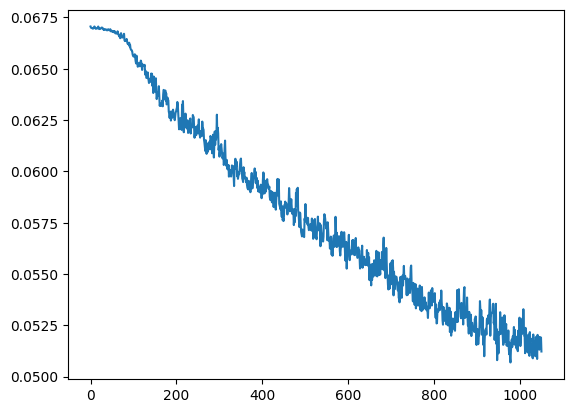

In [44]:
df_train, df_test = train_test_split(df3, test_size=0.1,  random_state=0)



corte=99.5


#max_diff=np.percentile([abs(df_train.H1),abs(df_train.L1)], corte )
max_diff=np.percentile([abs(df_train.C1)], corte )
max_PL=np.percentile([abs(df_train.buy_PL),abs(df_train.sell_PL)], corte )


#Coloca em escala de -1 e 1,  99.5% ddos dados
df_train[df3.columns[:-2]]/=max_diff
df_test[df3.columns[:-2]]/=max_diff

df_train[df3.columns[-2:]]/=max_PL
df_test[df3.columns[-2:]]/=max_PL





X_train=torch.Tensor(df_train.iloc[:,:-2].values).flip(1)
Y_train=torch.Tensor(df_train.iloc[:,-2:].values)


X_test=torch.Tensor(df_test.iloc[:,:-2].values).flip(1)
Y_test=torch.Tensor(df_test.iloc[:,-2:].values )




D_in=X_train.shape[1]
D_out=Y_train.shape[1]
D_h=25


'''
model=nn.Sequential(
    nn.Linear(D_in, D_h),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    #nn.Linear(D_h, D_h),
    #nn.ReLU(),
    #nn.Dropout(p=0.2),
    nn.Linear(D_h, D_out)
)
'''

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers,dropout=0.1):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True,dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        n=x.size(0)
        x=x.view(n,x.size(1),1 )
        h0 = torch.zeros(self.n_layers, n, self.hidden_dim).to(x.device) # Initial hidden state
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Output corresponding to the last timestep
        return out



model=GRU(input_dim=1, hidden_dim=25, output_dim=D_out, n_layers=2, dropout=0.1)


#Se tiver GPU disponivel usa a utiliza para acelerar o processo
if torch.cuda.is_available():
  X_train=X_train.cuda()
  X_test=X_test.cuda()
  Y_train=Y_train.cuda()
  Y_test=Y_test.cuda()
  model=model.cuda()





# Loss and optimizer
loss_func=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

epochs = 100
batch_size=5000   

losses=[]
for _ in range(epochs):
    permutation = torch.randperm(X_train.shape[0])
    for i in range(0,X_train.shape[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], Y_train[indices]
        
        optimizer.zero_grad() 
        y_pred = model(batch_x)
        loss = loss_func(y_pred, batch_y)
    
        loss.backward()
        optimizer.step()
    
        with torch.no_grad():
            losses+=[float(loss_func(model(X_test), Y_test).item())]

pd.Series(losses[int(epochs/2):]).plot.line()


model.eval()

Y_pred=model(X_test)
k=0.01
PL_total=Y_test[Y_pred[:,0]>k][:,0].sum()+Y_test[Y_pred[:,1]>k][:,1].sum()

#return PL_total





dft=pd.DataFrame()

dft[['buy_pred','sell_pred']]=pd.DataFrame( model(X_test).cpu().detach().numpy() )
dft[['buy','sell']]=pd.DataFrame(Y_test.detach().cpu().numpy() )


for i in range(20):
    k=i*0.01
    pl_total= dft[dft.buy_pred>k].buy.sum()+dft[dft.sell_pred>k].sell.sum()
    print('min:',f'{k:.2f} ', 'pl_total:', f'{pl_total:.2f}' )
